<a href="https://colab.research.google.com/github/larry-tableau/tableau/blob/main/AI_Newsletter_generator_using_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AI Newsletter Generator 🤖📰**

An intelligent newsletter generation system powered by CrewAI that automatically creates, validates, and formats AI-focused newsletters using a team of specialized AI agents.

**Features ✨**

🔍 Automated research of latest AI developments
* ✅ Multi-stage validation and fact-checking
* 📝 Template-based content generation
* 🔗 URL validation and cleaning
* 📊 Comprehensive error handling
* 🤝 Multiple specialized AI agents working together

**Prerequisites 📋**

* Python >= 3.10, <= 3.13
* Docker (for code execution in safe mode)
* Access to required API services

**Required API Keys 🔑**

The following API keys need to be set as environment variables:
* OPENAI_API_KEY - OpenAI API key
* ANTHROPIC_API_KEY - Anthropic API key
* SERPER_API_KEY - Serper.dev API key

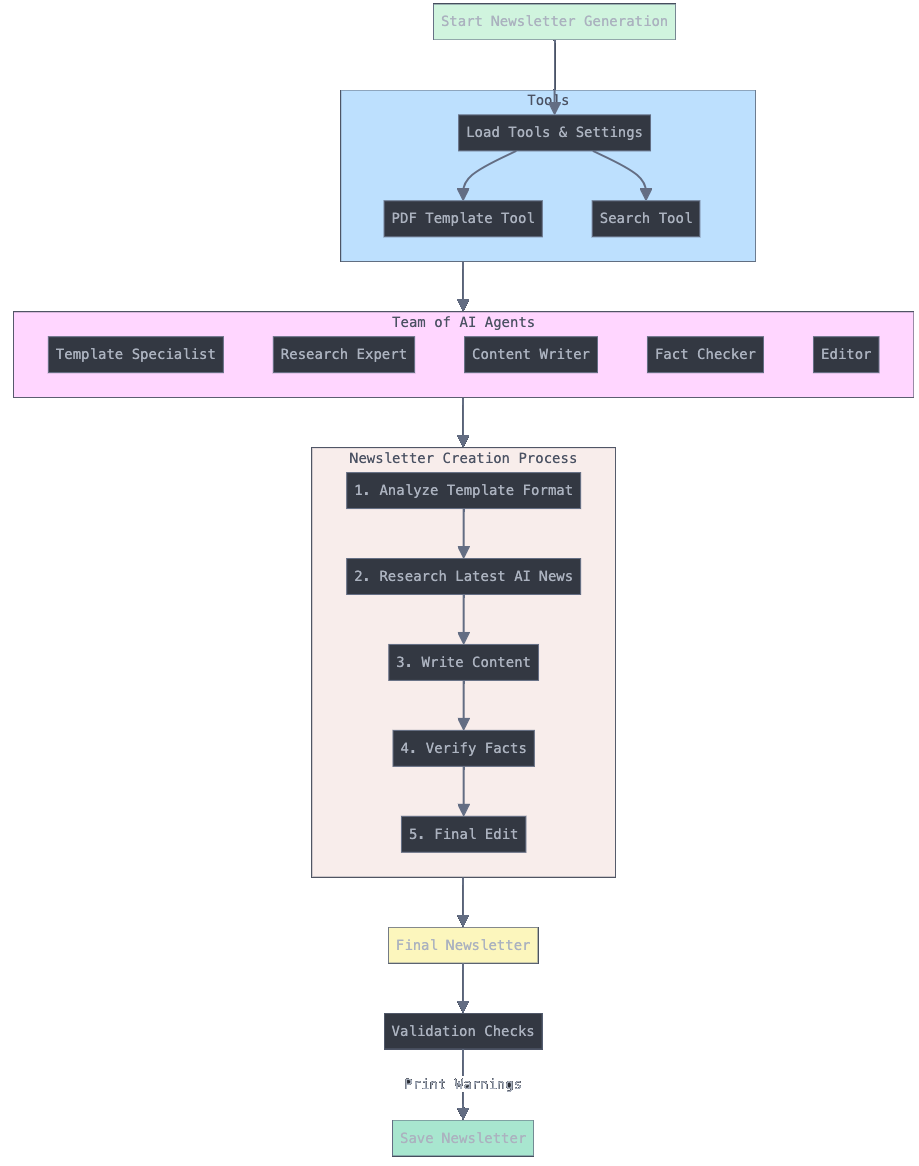

In [ ]:
import os
from crewai import Agent, Task, Crew, Process
from crewai_tools import SerperDevTool, PDFSearchTool
from crewai import LLM
from google.colab import userdata
from urllib.parse import urlparse
import requests
import re
from datetime import datetime, timedelta

# Initialize LLM
# llm = LLM(model="gpt-4o", temperature=0.5)
# llm = LLM(model='claude-3-5-haiku-20241022', temperature=0.5)
llm = LLM(model='claude-3-5-haiku-20241022', temperature =0.5)

start_date = (datetime.now() - timedelta(days=60)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')  # today

# Environment variables setup
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')
os.environ["SERPER_API_KEY"] = userdata.get('SERPER_API_KEY')

# Add this function after your imports
def clean_url(url):
    """Clean URL by removing trailing punctuation and parentheses"""
    url = url.rstrip('.,;:!?)]}\'\"')  # Remove trailing punctuation
    url = url.lstrip('([{\'\"')        # Remove leading brackets/quotes
    return url

# Then modify the extract_urls function to use clean_url
def extract_urls(text):
    """Extract URLs from text using improved regex"""
    # More comprehensive URL pattern
    url_pattern = r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+[^\s)}\]]*'
    urls = re.findall(url_pattern, text)
    # Clean each URL
    return [clean_url(url) for url in urls]

# And update the validate_url function for better error handling
def validate_url(url):
    """Validate if a URL is accessible and returns proper status code"""
    try:
        # Clean the URL before validation
        url = clean_url(url)

        # Configure session with appropriate headers
        session = requests.Session()
        session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        })

        # Try HEAD request first (faster)
        try:
            response = session.head(url, allow_redirects=True, timeout=10)
            if response.status_code == 405:  # Method not allowed
                # Fall back to GET request if HEAD is not supported
                response = session.get(url, allow_redirects=True, timeout=10)
        except requests.exceptions.RequestException:
            # If HEAD fails, try GET
            response = session.get(url, allow_redirects=True, timeout=10)

        return 200 <= response.status_code < 300

    except requests.exceptions.SSLError:
        # Try without SSL verification if SSL fails
        try:
            response = session.get(url, verify=False, allow_redirects=True, timeout=10)
            return 200 <= response.status_code < 300
        except:
            return False
    except Exception as e:
        print(f"Error validating URL {url}: {str(e)}")
        return False

def verify_template_variables(content, template_vars):
    """Verify all template variables are replaced"""
    missing_vars = []
    for var in template_vars:
        if f"{{{var}}}" in content:
            missing_vars.append(var)
    return missing_vars

# Initialize tools with configuration
search_tool = SerperDevTool(
    n_results=5,
    locale='au',
    search_params={
        "tbs": f"cdr:1,cd_min:{start_date},cd_max:{end_date}",
        "sort": "date",
    }
)
pdf_tool = PDFSearchTool(pdf="https://raw.githubusercontent.com/larry-deee/CrewAI/main/NewsletterFormat.pdf")

# PDF Template Processor Agent with enhanced verification
pdf_processor = Agent(
    role='PDF Format Specialist',
    goal='Process and analyze newsletter format templates with strict adherence to formatting requirements',
    backstory="""Expert in document formatting and template analysis. You meticulously validate
    template compliance and ensure all formatting guidelines are followed precisely.""",
    tools=[pdf_tool],
    llm=llm,
    respect_context_window=True,
    verbose=True
)

# Research Agent with enhanced fact-checking
researcher = Agent(
    role='AI News Researcher',
    goal='Gather and thoroughly verify the very latest AI developments with multiple sources (i.e. within the last few months of this year), include productivity tools for consultants.',
    backstory="""Specialized in AI industry research with a strong focus on fact verification and recency.
              You always prioritize content from 2024 and cross-reference information across multiple reliable sources.
              You specifically filter for content published in the last 90 days, with a strong preference for content
              from the current month. When searching, you explicitly include '2024' in your search queries and
              prioritize official announcements, press releases, and verified news sources.
              You always cross-reference information across multiple reliable sources and validate all URLs.""",
    tools=[search_tool, pdf_tool],
    llm=llm,
    respect_context_window=True,
    verbose=True
)

# Writer with enhanced template compliance
writer = Agent(
    role='Newsletter Writer',
    goal='Create engaging content while maintaining strict template adherence',
    backstory="""Experienced tech writer who excels at creating compelling narratives while
    ensuring perfect alignment with template requirements and formatting guidelines.""",
    tools=[search_tool, pdf_tool],
    llm=llm,
    respect_context_window=True,
    verbose=True
)

# Editor with enhanced validation
editor = Agent(
    role='Content Editor',
    goal='Ensure perfect quality, consistency, and template compliance',
    backstory="""Senior editor who meticulously validates all content, sources, and formatting.
    You verify every URL, fact, and template requirement before approval.""",
    tools=[pdf_tool],
    llm=llm,
    respect_context_window=True,
    verbose=True
)

# Enhanced Fact Checker
fact_checker = Agent(
    role='Fact Verification Specialist',
    goal='Verify accuracy of all information while maintaining template structure',
    backstory="""Expert in fact verification who validates every claim, URL, and source.
    You ensure 100% accuracy while preserving document formatting requirements.""",
    tools=[search_tool, pdf_tool],
    llm=llm,
    respect_context_window=True,
    verbose=True
)

# Define Tasks with enhanced validation
analyze_template = Task(
    description="""
    Analyze the newsletter template using {pdf_tool} search with strict validation:
    1. Extract and validate all formatting requirements
    2. Identify and verify section structures
    3. Document and validate style guidelines
    4. Create comprehensive formatting reference guide
    5. Identify and validate all template variables:
       - {month}: Current month
       - {year}: Current year
       - {date}: Current date
       - {issue_number}: Newsletter issue number
       - Any other variables in curly braces

    Ensure complete template coverage and variable validation.
    Format response as a valid JSON string, properly escaped.
    """,
    expected_output="""
    A strictly validated JSON document with:
    {
        "sections": [...],
        "formatting": {...},
        "styles": {...},
        "template_variables": {
            "found_variables": [
                {
                    "variable": "string",
                    "description": "string",
                    "location": "string"
                }
            ],
            "required_replacements": [
                {
                    "variable": "string",
                    "value": "string",
                    "context": "string"
                }
            ]
        }
    }
    """,
    output_file="template_check.md",
    agent=pdf_processor
)

research_news = Task(
    description="""
    Research and verify the latest AI developments using SerperDev search:
    1. Top Stories: Major verified AI announcements and releases this month and/or year
    2. Research Corner: Validated research breakthroughs
    3. Innovation Spotlight: Verified industry developments
    4. Market Analysis: Fact-checked market trends
    5. New Tools & Frameworks: Validated productivity tips
    6. Future Trends: Verified community insights

    Required validation:
    - Cross-reference all information across multiple sources
    - Verify all URLs are accessible and valid
    - Validate all claims with authoritative sources
    - Ensure all sources are recent and reliable

    Maintain strict template compliance throughout.
    """,
    expected_output="""
    A verified markdown document containing:
    1. Validated Top Stories
    2. Verified Research Corner
    3. Fact-checked Market Analysis
    4. Validated New Tools & Frameworks
    5. Verified Future Trends

    Each section must include:
    - Verified headline
    - Validated date
    - Fact-checked summary
    - Verified source URL
    """,
    output_file="researcher_results.md",
    agent=researcher
)

write_content = Task(
    description="""
    Create newsletter content with strict template compliance:
    - Implement all required sections exactly as specified
    - Follow formatting specifications precisely
    - Maintain consistent style throughout
    - Use proper markdown syntax

    Replace all template variables:
    - {month} → Current month
    - {year} → Current year
    - {issue_number} → Calculated issue number
    - {author} → Specified author or default
    - All other template variables

    Verify all content:
    - Cross-check all facts and claims
    - Validate all URLs
    - Ensure proper formatting
    - Verify template compliance
    """,
    expected_output="""
    A validated markdown newsletter with:
    1. Complete template compliance
    2. Verified content accuracy
    3. Validated URLs
    4. Proper formatting
    5. All variables replaced

    Include validation report:
    {
        "template_compliance": true,
        "content_verification": true,
        "url_validation": true,
        "variables_replaced": true
    }
    """,
    output_file="newsletter_draft.md",
    agent=writer
)

verify_facts = Task(
    description="""
    Comprehensive fact verification while maintaining template integrity:
    1. Verify every fact and claim with multiple sources
    2. Validate all dates and statistics
    3. Cross-reference all technical details
    4. Verify all URLs are accessible
    5. Confirm source reliability and authority
    6. Ensure template compliance throughout

    Generate detailed verification report.
    """,
    expected_output="""
    A comprehensive verification report containing:
    {
        "verified_claims": [
            {
                "claim": string,
                "status": "verified|corrected|removed",
                "sources": [string],
                "confidence": float
            }
        ],
        "validated_urls": [
            {
                "url": string,
                "status": "valid|invalid",
                "redirect_url": string
            }
        ],
        "template_compliance": {
            "status": boolean,
            "issues": [string]
        }
    }
    """,
    output_file="validation_check.md",
    agent=fact_checker
)

edit_newsletter = Task(
    description="""
    Final comprehensive review and validation:
    1. Verify complete template compliance
    2. Validate all sections and formatting
    3. Verify proper markdown syntax
    4. Ensure perfect template adherence (including emojis)
    5. Validate all URLs are accessible
    6. Cross-check all facts and claims
    7. Verify all template variables replaced
    8. Ensure it is current and the latest news

    Generate detailed quality report.
    """,
    expected_output="""
    Final validated newsletter package:
    1. Template-compliant markdown newsletter
    2. Comprehensive validation report:
    {
        "template_compliance": boolean,
        "content_verification": boolean,
        "url_validation": boolean,
        "variable_replacement": boolean,
        "formatting_validation": boolean,
        "section_compliance": boolean,
        "recent_events" : boolean
    }
    """,
    output_file="editorial_check.md",
    agent=editor
)

class NewsletterGenerator:
    def __init__(self, template_path: str):
        self.template_path = template_path

    def validate_output(self, result: str) -> str:
        """Validate the newsletter output"""
        # Extract and validate URLs
        urls = extract_urls(result)
        for url in urls:
            if not validate_url(url):
                print(f"Warning: Invalid URL detected: {url}")

        # Verify template variables
        template_vars = ['month', 'year', 'date', 'issue_number']
        missing_vars = verify_template_variables(result, template_vars)
        if missing_vars:
            print(f"Warning: Missing template variables: {missing_vars}")

        return result

    def generate(self) -> str:
        try:
            # Initialize crew with enhanced settings
            crew = Crew(
                agents=[pdf_processor, researcher, writer, fact_checker, editor],
                tasks=[analyze_template, research_news, write_content, verify_facts, edit_newsletter],
                process=Process.sequential,
                llm=llm,
                max_rpm=60,
                memory=True,
                verbose=True,
                planning=True

            )

            result = crew.kickoff()

            # Validate output
            if isinstance(result, (list, dict)):
                result = json.dumps(result)
            elif not isinstance(result, str):
                result = str(result)

            # Perform final validation
            result = self.validate_output(result)

            # Save validated newsletter
            output_path = "generated_newsletter.md"
            with open(output_path, "w") as f:
                f.write(result)

            return result

        except Exception as e:
            print(f"Error generating newsletter: {str(e)}")
            import traceback
            print(traceback.format_exc())
            raise

if __name__ == "__main__":
    template_path = pdf_tool
    generator = NewsletterGenerator(template_path)

    try:
        print("Initializing newsletter generation...")
        print(f"Using template: {template_path}")

        newsletter = generator.generate()

        print("Newsletter generated successfully!")
        print("Output saved to: generated_newsletter.md")

    except Exception as e:
        print(f"Failed to generate newsletter: {str(e)}")
        print("\nDebug information:")
        print(f"Template path: {template_path}")
        import sys
        print(f"Python version: {sys.version}")
        print("\nFull error trace:")
        import traceback
        print(traceback.format_exc())